# Demo 1: Single Layer Perceptron 
This demo we will demo code for using Perceptron model to solve the classification problem:
-   Problem: Defect detection classification (with the NEU surface defect dataset)
-   Dataset: NEU surface defect dataset <http://faculty.neu.edu.cn/songkechen/zh_CN/zhym/263269/list/index.htm>(NEU SDD)
-   Library packages:
    -   Numpy (Numpy arrays are very fast and can perform large computations in a very short time)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)
    -   TensorFlow (This is an open-source library that is used for DL/ML/AI)
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree, Metrics,...)
Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Downloads dataset, unpacking dataset,...
-   Transform it to input (features) and ouput (labels) where the model in Scikit-Learn can read, and training on,...
-   Normalize or standardlize dataset (we may do it after some evaluations on the raw data)
-   Devide dataset to trainset and testset (maybe one more validation_set)
## 1. Task 1: Constructing model by using TensorFlow library:
-   Create a single layer perceptron model
-   Training model on our trainset
## 2. Task 2: Evaluating the performance of trained model on the testset
-   Predict the label (which class) for each input image in the testset
-   Compute the metrics (quantitative measurements) 
    -   For example on Classification task: Accuracy, Precesion, Recall, Confusion Matrix, F1-Score, Cross-Entropy Loss,... 
*****************************************************************************

# Import all packages

In [66]:

import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


## 0. Task 0: Preparing Dataset

Go to the notebook file: Demo_Read_NEU_dataset.ipynb to get detail of demo code for this step

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [67]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.bmp')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    -   List of relative class for each image in the data folder
    """
    label_to_number = {"Cr":0,"In":1,"Pa":2,"PS":3,"RS":4,"Sc":5}
    list_img_paths = []
    list_labels = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(os.path.join(root,file))
                list_labels.append(label_to_number[file_name[:2]])
    return (list_img_paths,list_labels)


### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [68]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             list_labels:list,
             is_resize:bool= True,
             width:int = 8,
             height:int = 8) -> (np.array,np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   list_labels: The list of labels relative to each image in the list_img_paths
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    -   label_array with shape (N,)
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img)
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return (np.array(data),np.array(list_labels))

### 0.3. Getting data by using two previouse function

In [69]:
# Get the list of all path to images, and the list of relative labels
dir_NEUCLS = "/Users/user/Victor2023/Dataset/NEU-CLS"
list_img_paths,list_labels = get_all_img_label_path(input_dir=dir_NEUCLS,
                                                    img_suffix='.bmp')

width = 128
height = 128
X,y = get_data(list_img_paths=list_img_paths,
               list_labels=list_labels,
               is_resize=True,
               width=width,
               height= height)

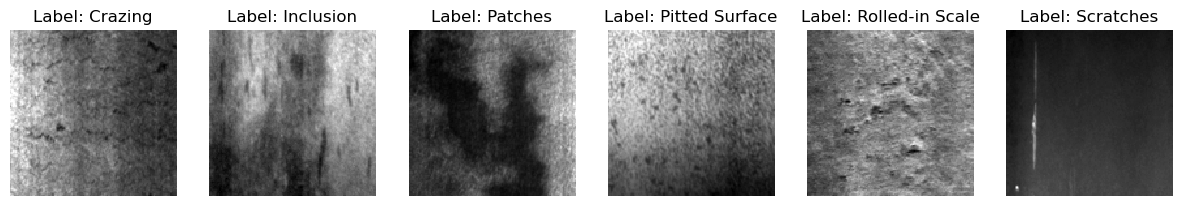

In [70]:
# Plotting some images to take an overview of our dataset
index_to_label = ["Crazing","Inclusion","Patches","Pitted Surface","Rolled-in Scale","Scratches"]
# Visualize one sample of each class
_, indices = np.unique(y,return_index=True) # get one index of each class
# Plot
_, axes = plt.subplots(nrows = 1,
                       ncols = len(indices),
                       figsize = (15,6))
for i in range(len(indices)):
    index = indices[i]
    axes[i].set_axis_off()
    axes[i].imshow(X[index], cmap = plt.cm.gray, interpolation= "nearest")
    axes[i].set_title(f"Label: {index_to_label[y[index]]}")

### Note!
The shape of data for KNN model should be (N_samples,N_features). In which:
-   N_samples: The total number of samples we have (number of images)
-   N_features: the number of features in each sample

Back to our data:
-   Data is image in grayscale we resize to same size (width,height), here is 128 x 128 pixels. Each pixels is one feature of sample, so totally we have 128*128 number of features for each sample.
-   We have to reshape our data from (N_samples,height,width) to (N_samples,height * width)


In [71]:
print("The currently shape of input dataset X is:", X.shape)

The currently shape of input dataset X is: (1800, 128, 128)


In [72]:
n_samples = X.shape[0]
X = X.reshape((n_samples,-1))
# Scaling feature from range [0,255] to range [0,1]
# Each pixel is a feature of input image, which has normally value in range [0,255] 
X = X/255
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# Convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)


In [73]:
print("The currently shape of input dataset X is:", X.shape)
print("The currently shape of dummy y is:", dummy_y.shape)


The currently shape of input dataset X is: (1800, 16384)
The currently shape of dummy y is: (1800, 6)


### 0.4. Deviding our dataset to trainset and testset

In [74]:
X_train,X_test,y_train,y_test = train_test_split(X,dummy_y,test_size=0.2,shuffle=False)

In [75]:
print("Number of samples in the train subset:", len(y_train))
print("Number of samples in the test subset:", len(y_test))

Number of samples in the train subset: 1440
Number of samples in the test subset: 360


## 1. Task 1: Constructing model by using TensorFlow library:

### 1.1. Creating a single layer perceptron model
The perceptron operation:

$$output = activation(dot(input,kernel)+ bias)$$

In [76]:
# Creating a perceptron model:
dim_output = 6
input_shape = (X.shape[1],)
perceptron = keras.Sequential([
    keras.layers.Dense(dim_output,
                       input_shape = input_shape,
                       activation = 'sigmoid')
    ])

In [77]:
# Show the model summary
perceptron.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6)                 98310     
                                                                 
Total params: 98,310
Trainable params: 98,310
Non-trainable params: 0
_________________________________________________________________


-   The input shape is 16384
-   The output shape is 6
-   The weight shape (kernel) is (16284,6)
-   The bias shape is 6
-   The total parameters is: $16248*6+6 = 98310$

### 1.2. Train and evaluate model:

In [92]:
epochs = 500
optimizer = 'adam'
loss = keras.losses.CategoricalCrossentropy()
q_metrics = [keras.metrics.CategoricalAccuracy()]
perceptron.compile(optimizer=optimizer,
                   loss = loss,
                   metrics=q_metrics)
history = perceptron.fit(X_train,y_train,validation_split=0.33,epochs=epochs,verbose=2)

Epoch 1/500
31/31 - 1s - loss: 1.0413 - categorical_accuracy: 0.7718 - val_loss: 0.1503 - val_categorical_accuracy: 0.9454 - 1s/epoch - 46ms/step
Epoch 2/500
31/31 - 0s - loss: 0.1061 - categorical_accuracy: 0.9803 - val_loss: 0.0782 - val_categorical_accuracy: 0.9853 - 417ms/epoch - 13ms/step
Epoch 3/500
31/31 - 0s - loss: 0.0880 - categorical_accuracy: 0.9824 - val_loss: 0.1059 - val_categorical_accuracy: 0.9706 - 177ms/epoch - 6ms/step
Epoch 4/500
31/31 - 0s - loss: 0.0948 - categorical_accuracy: 0.9803 - val_loss: 0.1350 - val_categorical_accuracy: 0.9601 - 144ms/epoch - 5ms/step
Epoch 5/500
31/31 - 0s - loss: 0.0905 - categorical_accuracy: 0.9865 - val_loss: 0.0917 - val_categorical_accuracy: 0.9769 - 446ms/epoch - 14ms/step
Epoch 6/500
31/31 - 1s - loss: 0.0821 - categorical_accuracy: 0.9855 - val_loss: 0.0752 - val_categorical_accuracy: 0.9874 - 511ms/epoch - 16ms/step
Epoch 7/500
31/31 - 0s - loss: 0.0985 - categorical_accuracy: 0.9824 - val_loss: 0.0822 - val_categorical_accur

In [95]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


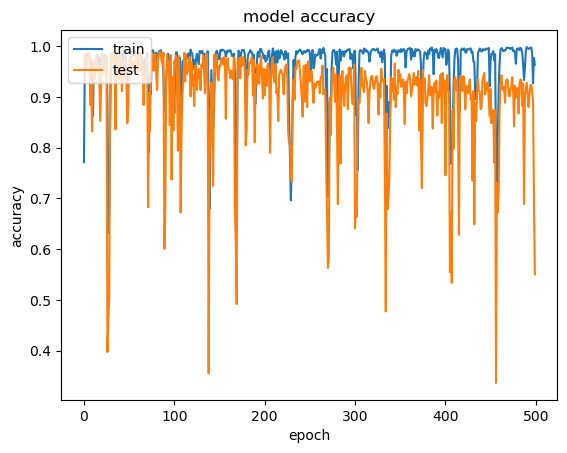

In [96]:
# Summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

## 2. Task 2: Evaluating the performance of trained model on the testset

### 2.1. Predict the label (which class) for each input image in the testset

In [86]:
output_test = perceptron.predict(X_test)

12/12 [==============================] - 0s 2ms/step


In [87]:
pred_test = np.argmax(output_test,axis=-1)
truth_test = np.argmax(y_test,axis=-1)

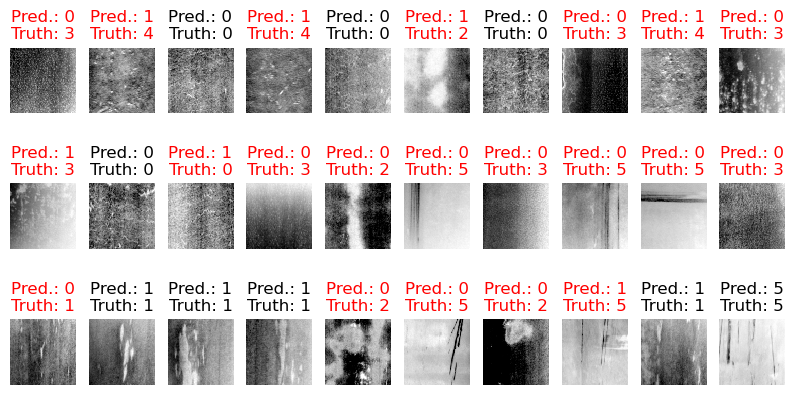

In [88]:
# Visualize the first 30 test samples and show their predicted digit value in the title.
_,axes = plt.subplots(nrows = 3,ncols = 10, figsize= (10,5))
for r in range(3):
    for c in range(10):
        index = r*10 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        pred_label = pred_test[index]
        true_label = truth_test[index]
        axes[r,c].imshow(image, cmap = plt.cm.gray_r, interpolation = "nearest")
        if pred_label == true_label:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}")
        else:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}",color = 'red')

### 2.2. Compute the metrics (quantitative measurements)

Text(0.5, 0.98, 'Number occurrences of each class on test set')

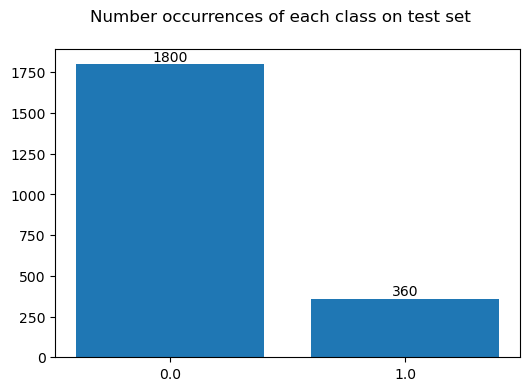

In [89]:
nb_classes = len(np.unique(y_test))
## Visual bar plot of number occurrences of each class in testset:
statistic_class = np.unique(y_test,return_counts=True)
categoricalClasses = [f'{C}' for C in statistic_class[0]]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(x = categoricalClasses, height = statistic_class[1],width = 0.8)
for i in range(nb_classes):
    ax.text(categoricalClasses[i],statistic_class[1][i],
            str(statistic_class[1][i]),ha='center',va = 'bottom')
fig.suptitle("Number occurrences of each class on test set")

In [90]:
# Classification report:
print(f"Classification report for classifier {perceptron}:\n"
      f"{metrics.classification_report(truth_test,pred_test,digits=4)}\n")

Classification report for classifier <keras.engine.sequential.Sequential object at 0x132f78eb0>:
              precision    recall  f1-score   support

           0     0.2183    0.7692    0.3401        65
           1     0.4022    0.5522    0.4654        67
           2     1.0000    0.1277    0.2264        47
           3     0.0000    0.0000    0.0000        69
           4     0.0000    0.0000    0.0000        45
           5     0.8000    0.2388    0.3678        67

    accuracy                         0.3028       360
   macro avg     0.4034    0.2813    0.2333       360
weighted avg     0.3937    0.3028    0.2460       360




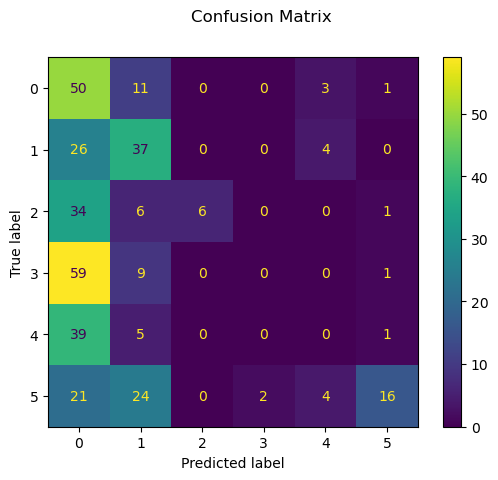

In [91]:
# Confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(truth_test,pred_test)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()